<div align="center">

# 쏘카 메모(memo) 분류하기
</div>

**주요 라이브러리 버전 체크 및 불러오기**

In [1]:
from importlib.metadata import version
import pandas
import gensim
import konlpy
import sentencepiece

print(pandas.__version__)
print(gensim.__version__)
print(konlpy.__version__)
print(version('sentencepiece'))

1.3.3
4.1.2
0.5.2
0.1.96


In [2]:
!pip install python-Levenshtein

In [66]:
import os
from collections import Counter
import pandas as pd
import gensim
from konlpy.tag import Komoran
import sentencepiece as spm
import matplotlib.pyplot as plt
import seaborn as sns


plt.rc('font', family='NanumBarunGothic')
%config InlineBackend.figure_format = 'retina'

### 1. 여러 카테고리에 대한 분류 시도

<br>

**데이터 불러오기**

---
데이터를 불러와 카테고리 분류를 위해 필요한 컬럼만 남길 예정.

In [4]:
PATH = os.getenv('HOME') + '/aiffel/socar_memo/data'

In [5]:
# load car dictionary
def load_car_dic():
    car_dic_file = open(PATH+'/carDic.txt','r')
    car_dic = set(car_dic_file.read().split('\n'))
    return car_dic

car_dic = load_car_dic()
print(len(car_dic)) #1433

1433


In [6]:
memo_data = pd.read_csv(PATH+'/car_inspect_info.tsv', sep='\t', lineterminator='\r')
memo_data.head()

,inspect_id,car_id,inspect_at,inspect_type,price,description
0,\n2504316,8421.0,2020-03-09,타이어수리(후우),6600.0,조수석뒤타이어 현장펑크수리
1,\n2401681,6654.0,2020-01-07,미션오일,120000.0,단양애니카_미션오일 교환
2,\n2384487,8563.0,2020-01-14,점화플러그,60000.0,당진세계모터스_점화플러그 교환
3,\n2384485,8563.0,2020-01-14,브레이크액,50000.0,당진세계모터스-브레이크오일 교환
4,\n2364371,6424.0,2020-01-06,브레이크액,40000.0,당진세계모터스_브레이크오일 교환


In [7]:
# drop columns
memo_data = memo_data.drop(columns=['inspect_id', 'car_id', 'price'])

In [8]:
display(memo_data[memo_data.isna().any(axis=1)])
display(memo_data.isnull().sum())

,inspect_at,inspect_type,description
18,NaN,NaN,NaN
20,NaN,NaN,NaN
22,NaN,NaN,NaN
58,NaN,NaN,NaN
169,NaN,NaN,NaN
...,...,...,...
272856,NaN,NaN,NaN
272858,NaN,NaN,NaN
272860,NaN,NaN,NaN
272862,NaN,NaN,NaN


inspect_at      18679
inspect_type    18754
description     18901
dtype: int64

In [9]:
# nan 모두 삭제
memo_data = memo_data.dropna() # drop nan row
memo_data.head()

,inspect_at,inspect_type,description
0,2020-03-09,타이어수리(후우),조수석뒤타이어 현장펑크수리
1,2020-01-07,미션오일,단양애니카_미션오일 교환
2,2020-01-14,점화플러그,당진세계모터스_점화플러그 교환
3,2020-01-14,브레이크액,당진세계모터스-브레이크오일 교환
4,2020-01-06,브레이크액,당진세계모터스_브레이크오일 교환


In [10]:
display(memo_data['inspect_type'].unique())

array(['타이어수리(후우)', '미션오일', '점화플러그', '브레이크액', '브레이크', '하이패스', '타이어수리(전우)',
       '타이어수리(후좌)', '사고수리', '블랙박스', '주차장위치', '후방카메라', '아이들러베어링', 'V리브드벨트',
       '전압관리', '타이어수리(전좌)', '컴파운드', 'CSA', '상품화점검', '휠캡', '운영상태점검',
       '키케이블', 'TCS', '기타', 'CSA_A/S', '배터리', '와이퍼', '전패드', '후패드', '사고조사',
       '세차점검', '엔진오일', '일반수리', '장애처리', '정기검사', '출장점검', '네비게이션', '얼라이먼트',
       '에어컨필터', '타이어일반', '재충전배터리', '타이어교체(전우)', '타이어교체(전좌)', '타이어교체(후우)',
       '타이어교체(후좌)'], dtype=object)

In [11]:
memo_data['inspect_type'].value_counts(normalize=False,
                              sort=True,
                              ascending=False).head(10)

일반수리         52094
엔진오일         34568
에어컨필터        30591
와이퍼          29651
장애처리         16598
출장점검         13374
세차점검          8351
타이어교체(전우)     7895
타이어교체(전좌)     7676
전패드           6159
Name: inspect_type, dtype: int64

In [12]:
c_memo_data = memo_data.loc[(memo_data['inspect_type'] == '엔진오일'), ['inspect_type', 'description']]

In [13]:
display(c_memo_data.head())
display(c_memo_data['description'].unique())

,inspect_type,description
75220,엔진오일,보령스팀닥터_엔진오일교환
75221,엔진오일,보령스팀닥터_엔진오일 교환
75222,엔진오일,당진세계모터스_엔진오일 교환
75223,엔진오일,당진세계모터스_엔진오일 교환
75224,엔진오일,교환 / 37w-1488


array(['보령스팀닥터_엔진오일교환', '보령스팀닥터_엔진오일 교환', '당진세계모터스_엔진오일 교환', ...,
       '스피드메이트 첨단2지구점 / 44w-0701', '엔진옫일교환_한국타이어', '엔진오일 교환 (티스테이션 부곡점 )'],
      dtype=object)

In [14]:
c_memo_data['description'].value_counts(normalize=False,
                              sort=True,
                              ascending=False).head(30)

(마인디즈) 엔진오일 교환          9856
가온오토) 엔진오일 교환           1695
교환                      1004
엔진오일 교환                  922
가온오토)엔진오일 교환             757
엔진오일교환_한국타이어             730
엔진오일교환                   709
가온오토)엔진오일교환              506
엔진오일                     458
엔진오일 교환 (티스테이션 부곡점)      442
용산산천점  엔진오일교환            351
스피드메이트 신창점               274
스피드메이트 첨단2지구점            250
엔진오일 교환(타이어프로 마산내서점)     186
대치점 엔진오일교환               182
부산부곡점 엔진오일 세트 교환         171
JJ motors                149
엔진오일 교체                  146
엔진오일 교환(동광정비)            144
삼전점 엔진오일교환               143
송파배명점 엔진오일교환             137
엔진오일 교환(타이어프로 울산점)       136
한타양재점   엔진오일교환           134
시민운동장점                   132
LS타워점 엔진오일 세트 교환         128
도림점   엔진오일교환             124
부산부곡점                    122
터미널카센타                    97
종로북촌점   엔진오일교환            94
엔진오일 교환(거제동광공업사)          91
Name: description, dtype: int64

In [15]:
c_memo_data1 = memo_data.loc[(memo_data['inspect_type'] == '일반수리'), ['inspect_type', 'description']]
display(c_memo_data1.head())
display(c_memo_data1['description'].unique())

,inspect_type,description
113553,일반수리,전구 1개
113554,일반수리,네비거치대
113555,일반수리,더블전구 1개
113556,일반수리,더블 전구 2개
113557,일반수리,주간주행등 교환


array(['전구 1개', '네비거치대', '더블전구 1개', ..., '전구 교체 (조수석 상향등)',
       '번호판 분실 재발급 인지세', '44호4311 번호판 분실 재발급 취등록세'], dtype=object)

In [16]:
c_memo_data1['description'].value_counts(normalize=False,
                              sort=True,
                              ascending=False).head(20)

부동액 1L 보충                946
탁송(소모품)                  647
정비픽업비 (티스테이션 부곡점)        633
탁송                       477
대치점  탁송(카로)              328
용산산천점  딜리버리              295
화성-볼펜,광택                 248
탁송비                      221
송파배명점  딜리버리              210
남양주 볼펜, 광택               207
용산산천점  탁송(카로직영)          186
장애처리                     172
도림점   딜리버리               161
삼전점  탁송(카로직영)            154
용산산천점  엔진 경고등 소거및배선정리    147
이동점검비                    139
대치점  엔진 경고등 소거및배선정리      137
(마인디즈) 부동액 1L 보충         136
고양 - 광택, 볼펜              130
주차비(소모품)                 128
Name: description, dtype: int64

노드에서는 비율이 가장 높은 일반수리로 카테고리를 분석하였으니, 이번 프로젝트에서는 엔진오일을 활용해서 노드와 동일한 방법으로 진행한다.

### FastText 활용

In [17]:
#sentenctePiece를 학습하기 위해서는 별도의 text 파일이 필요함
#따라서 이를 만드는 부분
with open(PATH+'/car_info_description.txt','w') as w, open(PATH+'/KCC150_100k.txt','r') as corpus:
    w.write('\n'.join(memo_data['description']))
    for idx, snt in enumerate(corpus.readlines()):
        w.write(snt)

In [18]:
#SentencePiece Train & load
spm.SentencePieceTrainer.Train(f'--input={PATH}/car_info_description.txt --model_prefix={PATH}/description --vocab_size=6000')
sp = spm.SentencePieceProcessor()
vocab_file = PATH+'/description.model'
sp.load(vocab_file)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/socar_memo/data/car_info_description.txt --model_prefix=/aiffel/aiffel/socar_memo/data/description --vocab_size=6000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/socar_memo/data/car_info_description.txt
  input_format: 
  model_prefix: /aiffel/aiffel/socar_memo/data/description
  model_type: UNIGRAM
  vocab_size: 6000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_

True

.cc(400) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=10488284
trainer_interface.cc(477) LOG(INFO) Done: 99.9502% characters are covered.
trainer_interface.cc(487) LOG(INFO) Alphabet size=1274
trainer_interface.cc(488) LOG(INFO) Final character coverage=0.999502
trainer_interface.cc(520) LOG(INFO) Done! preprocessed 354137 sentences.
unigram_model_trainer.cc(139) LOG(INFO) Making suffix array...
unigram_model_trainer.cc(143) LOG(INFO) Extracting frequent sub strings...
unigram_model_trainer.cc(194) LOG(INFO) Initialized 294077 seed sentencepieces
trainer_interface.cc(526) LOG(INFO) Tokenizing input sentences with whitespace: 354137
trainer_interface.cc(537) LOG(INFO) Done! 397820
unigram_model_trainer.cc(489) LOG(INFO) Using 397820 sentences for EM training
unigram_model_trainer.cc(505) LOG(INFO) EM sub_iter=0 size=150591 obj=1

**description 전처리**

---

In [19]:
def to_token(df, col):
    '''
    make sentence to subword sentence
    '''
    morph_description = []
    for _, row in df.iterrows():
        memo = row[col]
        sp_out = sp.encode_as_pieces(memo.replace('_',' ').replace('-',' ').replace('/',' ').replace('ㄴ',' ').replace('#',' ').replace('=',' ').replace(')',' ) ').replace('(',' ( '))
        morph_description.append(' '.join([token.replace('▁','') for token in sp_out]))

    df["subword_description"] = morph_description
    return df

memo_data = to_token(memo_data, "description")
memo_data.head()

,inspect_at,inspect_type,description,subword_description
0,2020-03-09,타이어수리(후우),조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크수리
1,2020-01-07,미션오일,단양애니카_미션오일 교환,단 양 애 니 카 미션오일 교환
2,2020-01-14,점화플러그,당진세계모터스_점화플러그 교환,당진세계모터스 점화플러그 교환
3,2020-01-14,브레이크액,당진세계모터스-브레이크오일 교환,당진세계모터스 브레이크오일 교환
4,2020-01-06,브레이크액,당진세계모터스_브레이크오일 교환,당진세계모터스 브레이크오일 교환


In [20]:
# FastText train data processing
ft_train = list(memo_data['subword_description'])
ft_train = [line.split() for line in ft_train]

print(len(ft_train))

254142


In [21]:
# FastText train part
model = gensim.models.fasttext.FastText(ft_train, 
                                        vector_size=300,
                                        window=5,
                                        min_count=1)
model.build_vocab(ft_train)
model.train(ft_train, total_examples=len(ft_train), epochs=10)

(13180181, 17249640)

In [23]:
# Word2Vec train part
model1 = gensim.models.word2vec.Word2Vec(ft_train,
                                         vector_size=300,
                                         window=5,
                                         min_count=1,
                                         epochs=10)

In [30]:
temp = model.wv.most_similar('타이어', topn=20)
temp1 = model1.wv.most_similar('타이어', topn=20)

In [31]:
ft_col_names = ['ft_token', 'ft_similarity']
w2v_col_names = ['w2v_token', 'w2v_similarity']

In [33]:
ft = pd.DataFrame(temp, columns=ft_col_names)
w2v = pd.DataFrame(temp1, columns=w2v_col_names)

In [47]:
comparison = pd.concat([ft, w2v], axis=1, join='inner')

In [48]:
comparison

,ft_token,ft_similarity,w2v_token,w2v_similarity
0,이어,0.830301,전우타이어,0.602388
1,앞타이어,0.810535,앞타이어,0.592893
2,타이어펑크,0.798175,전좌타이어,0.582812
3,후좌타이어,0.769872,타이어펑크,0.511219
4,전좌타이어,0.754862,후우타이어,0.511016
5,전우타이어,0.737759,후좌타이어,0.500462
6,후우타이어,0.725840,륜,0.491418
7,타이어공기압,0.637338,바퀴,0.481444
8,타이어교체,0.622759,펑크,0.475877
9,타이어테크,0.580506,타이어교체,0.450873


**키워드 추출 및 분류**

---

In [49]:
# check word most similarity
model.wv.most_similar('엔진오일', topn=10)

[('와이퍼', 0.6544137001037598),
 ('에어컨필터', 0.556540846824646),
 ('에어콘필터', 0.5245886445045471),
 ('에어컨', 0.510284423828125),
 ('항균필터', 0.49314117431640625),
 ('전패드', 0.47194793820381165),
 ('와이퍼브러쉬', 0.46999412775039673),
 ('필터', 0.4580807089805603),
 ('김천율곡점', 0.45071807503700256),
 ('06', 0.4399259388446808)]

In [50]:
model.wv.most_similar('교환', topn=10)

[('교체', 0.5644416213035583),
 ('타이어교환', 0.5039736032485962),
 ('항균필터교환', 0.4911036789417267),
 ('전좌타이어교환', 0.4556201994419098),
 ('방문점검', 0.4445664882659912),
 ('위치교환', 0.4313737750053406),
 ('일반', 0.4187207520008087),
 ('전우타이어교환', 0.4183083474636078),
 ('타이어위치교환', 0.4130127727985382),
 ('에어컨필터교환', 0.41038426756858826)]

In [51]:
def exclusion(word_list):
    '''
    most_similar의 단어를 평균 이상만 추림
    '''
    count = sum([score for _, score in word_list])
    avg = count / len(word_list)
  
    up_word = []
    for w, s in word_list:
        if s > avg:
            up_word.append(w)
  
    return up_word

In [52]:
# 라이트, 전구 에서 나온 단어들 평균 이상만 저장
light = model.wv.most_similar('라이트', topn=20)
light_word = exclusion(light)
light = model.wv.most_similar('전구', topn=20)
light_word.extend(exclusion(light))

light_word.append('라이트')
light_word.append('전구')

light_word = set(light_word)

# 경고등도 평균 이상만 저장
error = model.wv.most_similar('경고등', topn=10)
error_word = exclusion(error)
error_word.append('경고등')

print(light_word)
print('')
print(error_word)

{'헤드라이트', '전구', '주행등', '라이트전구', '브레이크전구', '미등', '라이', '전조등', '백색더블', '브레이크등', '안개등', '하향등', '라이트', '주간주행등', '주간'}

['공기압경고등', '라이트경고등', '경고', '엔진체크등', '고장코드', '경고등']


In [53]:
# 매핑 테이블 작성
mapping_table = {'내비게이션':'네비게이션', '내비':'네비게이션', '네비':'네비게이션', \
                  '딜리버리':'탁송', '탁송비':'탁송', \
                  '브레이크 오일':'브레이크액', '브레이크오일':'브레이크액', \
                  '라디오':'오디오'}

# "라이트" 관련 단어 매핑 테이블 추가
light_mapping = dict()
for word in light_word:
    light_mapping[word] = '라이트'

mapping_table.update(light_mapping)

# "경고등" 관련 단어 매핑 테이블 추가
error_mapping = dict()
for word in error_word:
    error_mapping[word] = '경고등'

mapping_table.update(error_mapping)

print(mapping_table)

{'내비게이션': '네비게이션', '내비': '네비게이션', '네비': '네비게이션', '딜리버리': '탁송', '탁송비': '탁송', '브레이크 오일': '브레이크액', '브레이크오일': '브레이크액', '라디오': '오디오', '헤드라이트': '라이트', '전구': '라이트', '주행등': '라이트', '라이트전구': '라이트', '브레이크전구': '라이트', '미등': '라이트', '라이': '라이트', '전조등': '라이트', '백색더블': '라이트', '브레이크등': '라이트', '안개등': '라이트', '하향등': '라이트', '라이트': '라이트', '주간주행등': '라이트', '주간': '라이트', '공기압경고등': '경고등', '라이트경고등': '경고등', '경고': '경고등', '엔진체크등': '경고등', '고장코드': '경고등', '경고등': '경고등'}


In [54]:
#total 45 category
category = set(memo_data['inspect_type'])
print(len(category))

45


In [55]:
def noun_phrase(words):
    result = []

    for index, token in enumerate(words):
        if (token in car_dic) or (token in category):
            #명사구 check
            if (''.join(words[index : index +2]) in car_dic) or (''.join(words[index : index +2]) in category):
                result.append(''.join(words[index : index +2]))
            #명사구 X
            result.append(token)
    return result

def find_category(row):
    # word base
    line = row['description'].replace('_',' ').replace('-',' ').replace('/',' ').replace('ㄴ',' ').replace('#',' ').replace('=',' ').replace(')',' ) ').replace('(',' ( ')
    car_token = noun_phrase(line.upper().split())
    # subword base
    car_token.extend(noun_phrase(row['subword_description'].upper().split()))
    return set(car_token)

In [56]:
subword_list = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '일반수리':
        car_words = find_category(row) #find word in car_dic
    
        if len(car_words) >= 1:  #car_words more than one
            subword_list.extend(car_words)

subword_list = [subword for subword in subword_list if subword != '']
subword_counter = Counter(subword_list) #car_dic에 포함되는 단어 + category에 포함되는 단어
subword_sort = sorted(subword_counter.items(), key=lambda x:x[1], reverse=True)
subword_top20 = [(key, value) for key, value in subword_sort[:20]]

print(subword_top20)

[('전구', 4971), ('엔진', 1931), ('전조등', 1380), ('브레이크', 1321), ('타이어', 824), ('센서', 609), ('시트', 581), ('도어', 528), ('유리', 510), ('휠', 497), ('에어컨', 482), ('디스크', 465), ('장애처리', 459), ('스로틀바디', 454), ('제동등', 432), ('연료', 396), ('커버', 341), ('범퍼', 320), ('배터리', 305), ('암', 300)]


In [57]:
def re_ranking(word_list):
    '''
    이전에 카테고리 카운팅된 subword_counter를 기준으로 Recategoring
    IF. 2개 이상의 카테고리 단어가 한 문장에서 등장할 경우, max 값 카테고리를 취함
    '''
    max_word = (None, -99)
    for word in word_list:
        # 단어가 mapping table에 포함되는 경우
        # mapping table Key word를 반환함
        if word in mapping_table:
            word = mapping_table.get(word)

        # 단어가 2개이상 선택되는 경우, 고빈도 word를 취함
        if subword_counter[word] > max_word[1]:
            max_word = (word, subword_counter[word])

    return max_word[0]

In [58]:
"""
find more best category from 엔진오일
"""
category_count = 0
recategory_count = 0
recategory = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '엔진오일':
        carWords = find_category(row) #find word in carDic
        recat = re_ranking(carWords)
        recategory.append(recat)
    
        category_count += 1
        if recat != None:
            recategory_count += 1 

    else:
        recategory.append(None)

memo_data['recategory'] = recategory #append recategory columns

memo_data = memo_data[['inspect_at', 'inspect_type','recategory','description','subword_description']] #change columns order
memo_data.to_csv(PATH+'/car_inspect_info_NEW.tsv', mode='w')

memo_data.head()

,inspect_at,inspect_type,recategory,description,subword_description
0,2020-03-09,타이어수리(후우),None,조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크수리
1,2020-01-07,미션오일,None,단양애니카_미션오일 교환,단 양 애 니 카 미션오일 교환
2,2020-01-14,점화플러그,None,당진세계모터스_점화플러그 교환,당진세계모터스 점화플러그 교환
3,2020-01-14,브레이크액,None,당진세계모터스-브레이크오일 교환,당진세계모터스 브레이크오일 교환
4,2020-01-06,브레이크액,None,당진세계모터스_브레이크오일 교환,당진세계모터스 브레이크오일 교환


In [59]:
print('엔진오일 카테고리 개수 : ', category_count)
print('엔진오일 카테고리중 sub카테고리 변경 개수 : ', recategory_count)

엔진오일 카테고리 개수 :  34568
엔진오일 카테고리중 sub카테고리 변경 개수 :  25337


In [60]:
recategory_counter = Counter(recategory)
recategory_counter_sorted = sorted(recategory_counter.items(), key=lambda x:x[1], reverse=True)
recategory_top20 = [(key, value) for key, value in recategory_counter_sorted[:21]]
print(recategory_top20)

[(None, 228805), ('엔진오일', 25171), ('타이어', 53), ('휠', 30), ('엔진', 18), ('오일', 17), ('지프', 15), ('암', 14), ('스테이션', 7), ('월', 6), ('와이퍼', 3), ('배터리', 1), ('펌프', 1), ('에어컨', 1)]


In [61]:
# 엔진오일에 해당하는 row만 추림
normal = memo_data.loc[memo_data['inspect_type'] == '엔진오일'].copy()

#pandas inspect_at column to datetime object
normal['dates'] = pd.to_datetime(normal['inspect_at'], format='%Y-%m-%d', errors='raise')

normal.head()

,inspect_at,inspect_type,recategory,description,subword_description,dates
75220,2020-01-31,엔진오일,None,보령스팀닥터_엔진오일교환,보 령 스 팀 닥 터 엔진오일교환,2020-01-31
75221,2020-01-13,엔진오일,엔진오일,보령스팀닥터_엔진오일 교환,보 령 스 팀 닥 터 엔진오일 교환,2020-01-13
75222,2020-01-14,엔진오일,엔진오일,당진세계모터스_엔진오일 교환,당진세계모터스 엔진오일 교환,2020-01-14
75223,2020-01-14,엔진오일,엔진오일,당진세계모터스_엔진오일 교환,당진세계모터스 엔진오일 교환,2020-01-14
75224,2020-10-14,엔진오일,None,교환 / 37w-1488,교환 37 w 14 88,2020-10-14


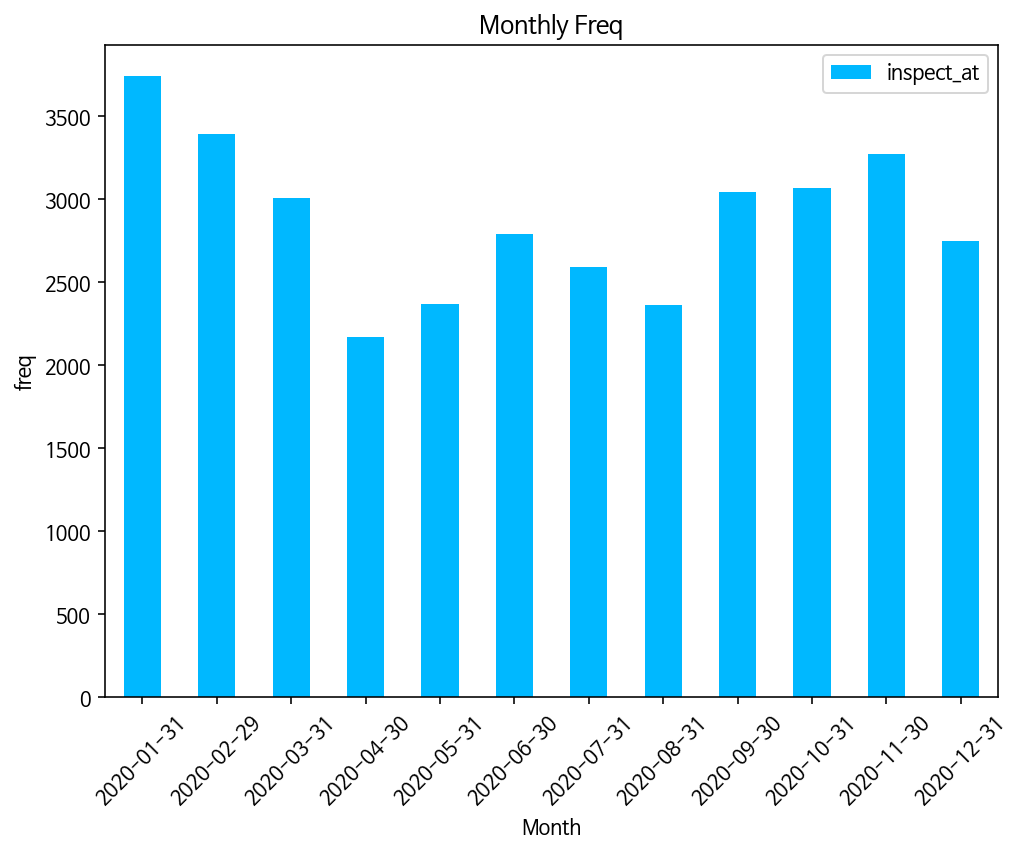

In [62]:
monthly = normal.groupby(pd.Grouper(key='dates', freq='M')).count()
monthly = monthly['inspect_at']
monthly = monthly.reset_index() #dates가 index인데, 이를 제거해줌(column으로 변경)
monthly['dates_str'] = monthly['dates'].apply(lambda x: str(x)[:10]) #datetime to str

plt.rcParams["figure.figsize"] = (8, 6)
monthly.plot(x='dates_str',y='inspect_at', color='#00B8FF', kind='bar') #Socar color

plt.xticks(rotation=45)
plt.title('Monthly Freq')
plt.xlabel('Month')
plt.ylabel('freq')

plt.savefig(PATH+'/Monthly_freq.png')
plt.show()

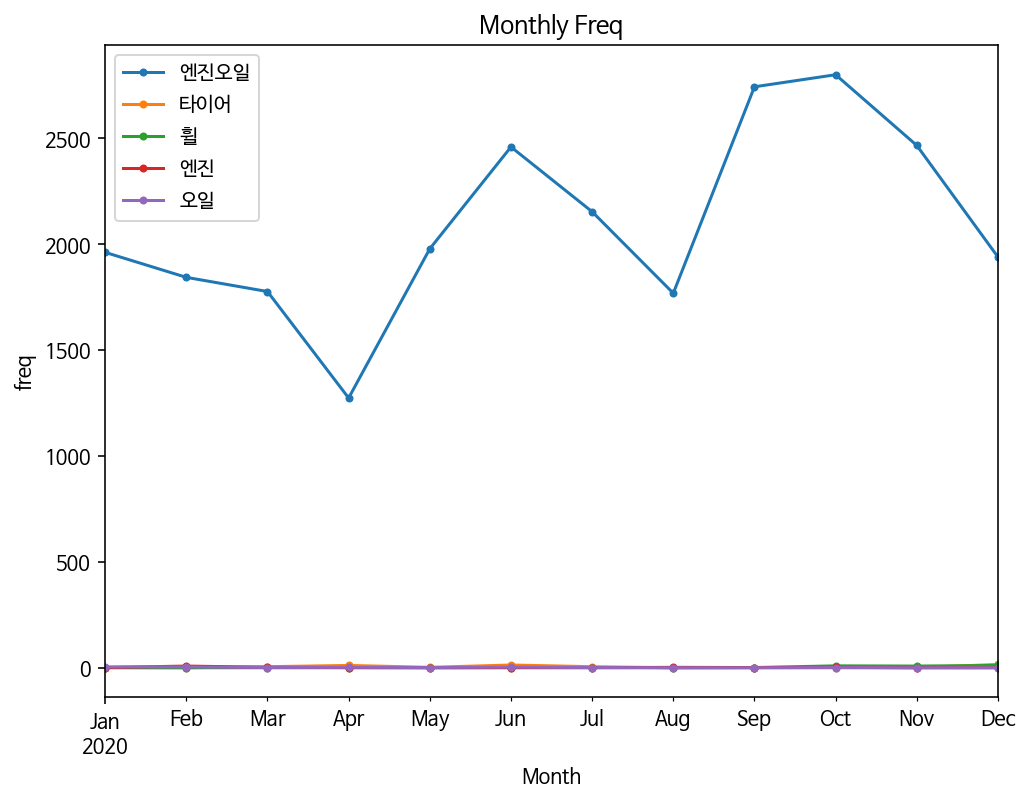

In [63]:
# recategory freq Top 5
temp = pd.DataFrame()
for word, count in recategory_top20[1:6]:
    temp[word] = normal.groupby(pd.Grouper(key='dates', freq='M'))['recategory'].apply(lambda x: x[x == word].count())

temp.plot(marker='.')
plt.title('Monthly Freq')
plt.xlabel('Month')
plt.ylabel('freq')
plt.savefig(PATH+'/recategory_top5.png')
plt.show()

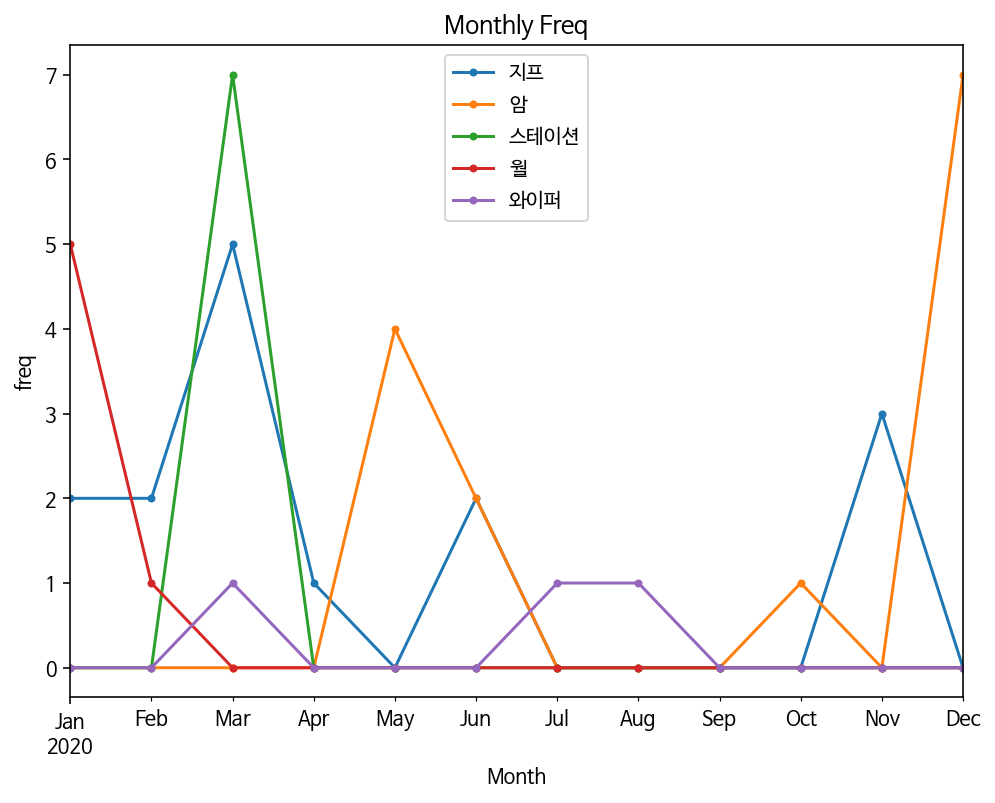

In [64]:
# recategory freq Top 6-10
temp = pd.DataFrame()
for word, count in recategory_top20[6:11]:
    temp[word] = normal.groupby(pd.Grouper(key='dates', freq='M'))['recategory'].apply(lambda x: x[x == word].count())

temp.plot(marker='.')
plt.title('Monthly Freq')
plt.xlabel('Month')
plt.ylabel('freq')
plt.savefig(PATH+'/recategory_6_10.png')
plt.show()